In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

from sqlalchemy import create_engine, inspect, distinct, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()


['measurement', 'station']

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
inspector = inspect(engine)
measurement_columns = inspector.get_columns("measurement")
for c in measurement_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
inspector = inspect(engine)
station_columns = inspector.get_columns("station")
for c in station_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Save references to each table
Measurements = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.

recent_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
recent_date

('2017-08-23',)

In [12]:
# Calculate the date one year from the last date in data set.
latest_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')
previous_year_date = latest_date - dt.timedelta(days=365)
print(previous_year_date)

2016-08-23 00:00:00


In [13]:
prcp_values = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > '2016-08-22').\
    order_by(Measurements.date).all()




In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 




# Perform a query to retrieve the data and precipitation scores
prcp_values = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > '2016-08-22').\
    order_by(Measurements.date).all()
lastdate = session.query(func.max(Measurements.date)).\
            scalar()

dt_lastdate= dt.datetime.strptime(lastdate,"%Y-%m-%d").date()
dt_startdate = dt_lastdate - dt.timedelta(days=365)
startdate = dt_startdate.strftime("%Y-%m-%d")

query = session.query(Measurements).\
            filter(Measurements.date.between(startdate,lastdate)).\
            all()










In [28]:
sel = [Measurements.date, 
       func.sum(Measurements.prcp)]
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > '2016-08-22').\
    order_by(Measurements.date).all()
# Sort the dataframe by date
precipitation_df = pd.DataFrame(precipitation, columns=['measurement_date', 'precipitation'])
precipitation_df.dropna(axis=0, how='any', inplace= True)
precipitation_df.sort_values(by='measurement_date')
precipitation_df.set_index('measurement_date', inplace=True)
precipitation_df.head()

,precipitation
measurement_date,
2016-08-23,0.0
2016-08-23,3.8
2016-08-23,1.3
2016-08-23,0.5
2016-08-23,45.5


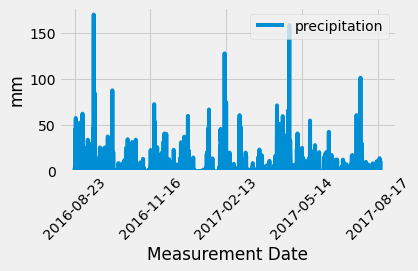

In [30]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot()
plt.ylim(0,)
plt.xticks(rotation=45)
plt.xlabel('Measurement Date')
plt.ylabel('mm')
plt.tight_layout()
plt.show()

In [33]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()


,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(distinct(Measurements.station))).all()

[(9,)]

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurements.station, 
       func.count(Measurements.date)]
active_stations = session.query(*sel).\
        group_by(Measurements.station).\
        order_by(func.count(Measurements.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurements.station,
       func.min(Measurements.tobs), 
       func.max(Measurements.tobs),
       func.avg(Measurements.tobs)]
active_station_temp_summary = session.query(*sel).\
        filter(Measurements.station == 'USC00519281').\
        group_by(Measurements.station)
for station in active_station_temp_summary:
    print(station)

('USC00519281', 12.2, 29.4, 22.03582251082252)


In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurements.date, 
       Measurements.tobs]
station_temps = session.query(*sel).\
        filter(func.strftime(Measurements.date) >= recent_date, Measurements.station == 'USC00519281').\
        group_by(Measurements.date).\
        order_by(Measurements.date).all()
station_temps_df = pd.DataFrame(station_temps, columns=['Measurements Date', 'Temperature'])
station_temps_df.head()

InterfaceError: (sqlite3.InterfaceError) Error binding parameter 0 - probably unsupported type.
[SQL: SELECT measurement.date AS measurement_date, measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE strftime(measurement.date) >= ? AND measurement.station = ? GROUP BY measurement.date ORDER BY measurement.date]
[parameters: (('2017-08-23',), 'USC00519281')]
(Background on this error at: https://sqlalche.me/e/14/rvf5)

# Close session

In [ ]:
# Close Session
session.close()